# AI 4 StoryLines - Baseline LR

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [1]:
from dataclasses import dataclass
from pathlib import Path

import autoroot
import cartopy.crs as ccrs
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from bayesevt._src.utils.io import get_list_filenames
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression
from utils import (
    interpolate_rectilinear_grid,
    plot_contour,
    plot_imshow,
    plot_pcolormesh,
)

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

AssertionError: Cartopy is only supported with Matplotlib 3.4 or greater.

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [2]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [3]:
# load covariates
df = pd.read_csv(Path(save_dir).joinpath("covariates.csv"), index_col=0)
# load qoi
ds = xr.open_dataset(Path(save_dir).joinpath("qoi.nc"))
models = [
    "access_cm2",
    "access_esm1_5",
    "bcc_csm2_mr",
    "cams_csm1_0",
    "canesm5",
    "cmcc_esm2",
    "cnrm_cm6_1",
    "cnrm_cm6_1_hr",
    "cnrm_esm2_1",
    "e3sm_1_0",
    "ec_earth3",
    "ec_earth3_cc",
    "ec_earth3_veg",
    "ec_earth3_veg_lr",
    "fgoals_g3",
    "gfdl_cm4",
    "gfdl_esm4",
    "ipsl_cm6a_lr",
    "kace_1_0_g",
    "miroc_es2l",
    "mpi_esm1_2_hr",
    "mpi_esm1_2_lr",
    "mri_esm2_0",
    "noresm2_lm",
    "noresm2_mm",
    "taiesm1",
    "ukesm1_0_ll",
]

# only select valid models
ds = ds.sel(model=models)
df = df[df["model"].map(lambda x: x in models)]

# quick check
assert df.model.values.sort() == ds.model.values.sort()

In [4]:
ds

<xarray.Dataset> Size: 132kB
Dimensions:      (lon: 21, lat: 19, model: 27)
Coordinates:
  * lon          (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat          (lat) float64 152B 26.25 28.75 31.25 ... 66.25 68.75 71.25
  * model        (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
    land_mask    (lat, lon) int16 798B ...
Data variables:
    tasmax       (model, lat, lon) float32 43kB ...
    tasmax_norm  (model, lat, lon) float64 86kB ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

We see that we have the `4` covariates and the `19x21` grid points.

Linear Regression only works with a 1D vector. 
So we need to flatten the `u` variable.

## Baseline Model - Linear Regression

#### Input Data

In [5]:
covariate_names = ["sst_norm", "sm_norm", "z500_norm"]
qoi_names = ["tasmax_norm"]
x = df.sort_values(by=["model"])[covariate_names].values
u = ds.sortby("model").tasmax_norm.stack(spatial=["lat", "lon"]).values

#### Model

In [45]:
from sklearn import ensemble

# reg = linear_model.Ridge(alpha=0.0)
reg = ensemble.RandomForestRegressor(n_estimators=5)
reg.fit(x, u)

RandomForestRegressor(n_estimators=5)

In [46]:
u_pred = reg.predict(x)

### Post-Model Analysis

We can extract the parameters for the regression model.
The coefficient corresponds to the slope of the regression model.

In [47]:
reg.feature_importances_

array([0.426081  , 0.25965939, 0.31425962])

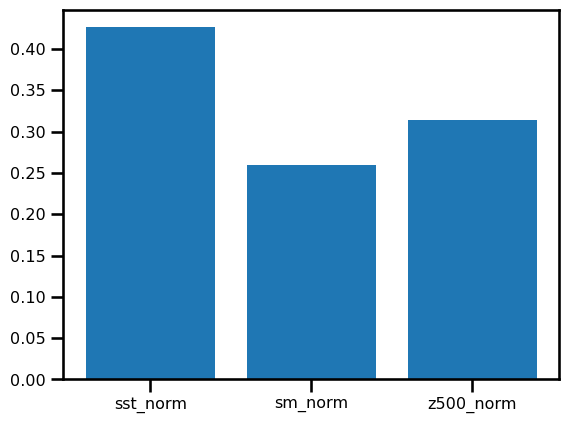

In [48]:
fig, ax = plt.subplots()

ax.bar(x=covariate_names, height=reg.feature_importances_)

plt.show()

### Permutation Analysis

In [49]:
from sklearn.inspection import permutation_importance

In [50]:
r = permutation_importance(reg, x, u, n_repeats=30, random_state=0)

In [51]:
r

{'importances_mean': array([0.60024562, 0.38153472, 0.56998854]),
 'importances_std': array([0.10532204, 0.08376003, 0.09072038]),
 'importances': array([[0.67661559, 0.43626061, 0.59393144, 0.53030972, 0.56832745,
         0.66535567, 0.66326893, 0.56517655, 0.65738324, 0.44638679,
         0.79852802, 0.77818299, 0.51408268, 0.70654022, 0.60666212,
         0.66308518, 0.71232242, 0.53565538, 0.56596244, 0.6784344 ,
         0.65799808, 0.47010497, 0.50135592, 0.50986209, 0.54838979,
         0.36445862, 0.78458108, 0.59035738, 0.5407527 , 0.67703608],
        [0.28274651, 0.34922538, 0.41954002, 0.19800734, 0.4635895 ,
         0.44238756, 0.49240778, 0.38825223, 0.45461763, 0.40012209,
         0.31691247, 0.16545179, 0.39428157, 0.29220868, 0.30469711,
         0.45213238, 0.35150456, 0.33790115, 0.35433064, 0.4324889 ,
         0.4098673 , 0.36472179, 0.41024856, 0.50961371, 0.51919874,
         0.34738175, 0.29427105, 0.46303437, 0.36859526, 0.46630383],
        [0.72459222, 0.6

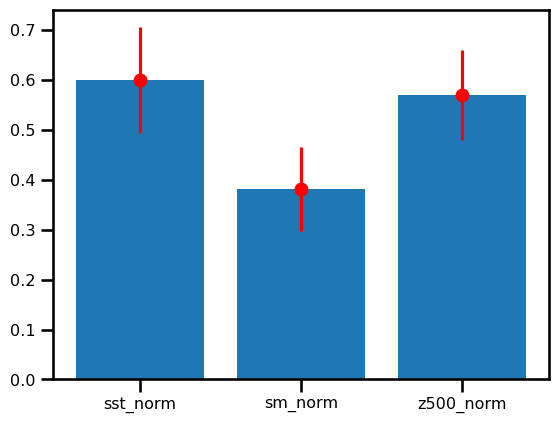

In [52]:
fig, ax = plt.subplots()

ax.bar(x=covariate_names, height=r["importances_mean"])
ax.errorbar(
    x=covariate_names,
    y=r["importances_mean"],
    yerr=r["importances_std"],
    fmt="o",
    color="r",
)

plt.show()

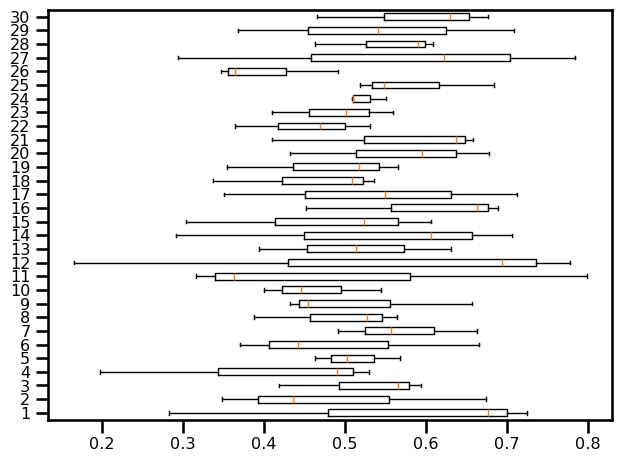

In [61]:
fig, ax = plt.subplots()

ax.boxplot(r["importances"], vert=False)
# ax.errorbar(x=covariate_names, y=r["importances_mean"], yerr=r["importances_std"], fmt="o", color="r")
plt.tight_layout()
plt.show()

In [53]:
ds.tasmax_norm.values.min(), ds.tasmax_norm.values.max()

(-0.945316501608477, 4.926493386827107)

Now, we will add each of these to our dataset so that we can see our

In [54]:
reg.coef_.shape

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [55]:
# sea surface height
ds = ds.stack(spatial=["lat", "lon"])
# ds["weights"] = (("spatial", "covariate"), reg.coef_)
# ds["bias"] = (("spatial",), reg.intercept_)
ds["pred"] = (
    (
        "model",
        "spatial",
    ),
    u_pred,
)
ds = ds.assign_coords(
    {
        "covariate": ["sst", "sm", "z500"],
    }
)
ds = ds.unstack()

## Analysis Dataset

### R2 Score

In [56]:
from sklearn.metrics import r2_score

In [57]:
ds = ds.stack(spatial=["lat", "lon"])
score = r2_score(
    y_true=ds.tasmax_norm.values, y_pred=ds.pred.values, multioutput="raw_values"
)
ds["score"] = (("spatial"), score)
ds = ds.unstack()

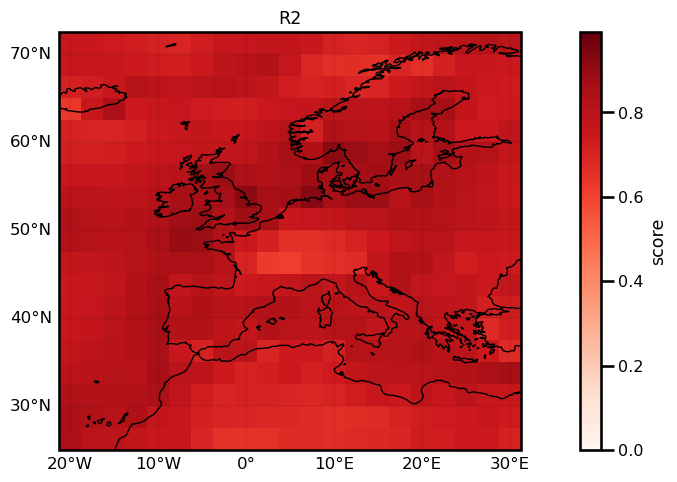

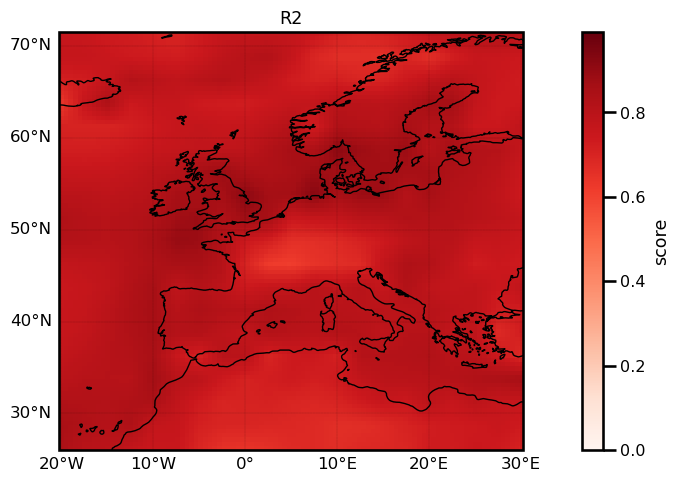

In [58]:
score = ds.score

plot_pcolormesh(
    score,
    "R2",
    vmin=0.0,
    vmax=0.99,
    cmap="Reds",
)

# interpolate
score = score.interp(
    lon=np.linspace(score.lon.values.min(), score.lon.values.max(), 100),
    lat=np.linspace(score.lat.values.min(), score.lat.values.max(), 100),
    method="linear",
)

plot_imshow(score, "R2", vmin=0.0, vmax=0.99, cmap="Reds", num_levels=None);

### Plot Bias

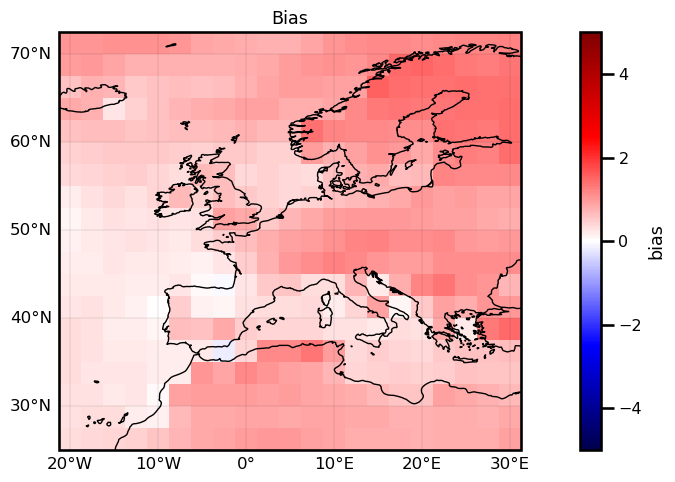

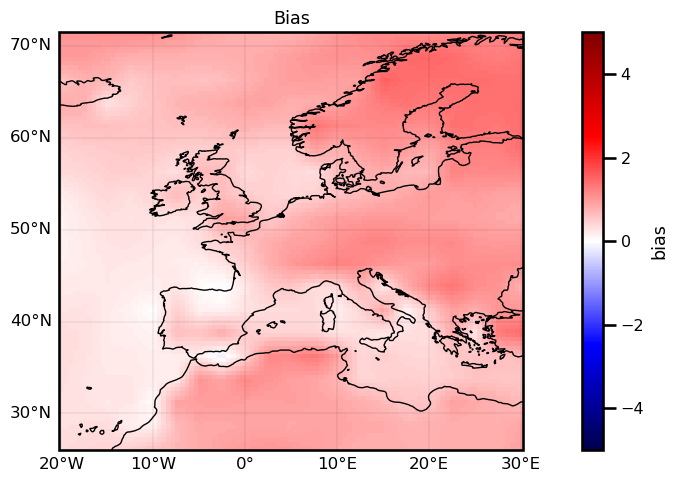

In [131]:
# plot weights
bias = ds.bias
plot_pcolormesh(bias, variable="Bias", vmin=-5.0, vmax=5.0, cmap="seismic")

# interpolate
bias = bias.interp(
    lon=np.linspace(bias.lon.values.min(), bias.lon.values.max(), 100),
    lat=np.linspace(bias.lat.values.min(), bias.lat.values.max(), 100),
    method="linear",
)

plot_imshow(bias, "Bias", vmin=-5.0, vmax=5.0, cmap="seismic", num_levels=None);

In [132]:
def plot_maps(covariate, variable_name):

    # plot weights
    ds_subset = ds.weights.sel(covariate=covariate)
    plot_pcolormesh(
        ds_subset, variable=variable_name, vmin=-2.0, vmax=2.0, cmap="seismic"
    )

    # interpolate
    ds_subset = ds_subset.interp(
        lon=np.linspace(ds_subset.lon.values.min(), ds_subset.lon.values.max(), 100),
        lat=np.linspace(ds_subset.lat.values.min(), ds_subset.lat.values.max(), 100),
        method="linear",
    )

    plot_imshow(
        ds_subset, variable_name, vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=None
    );

### Sea Surface Temperature

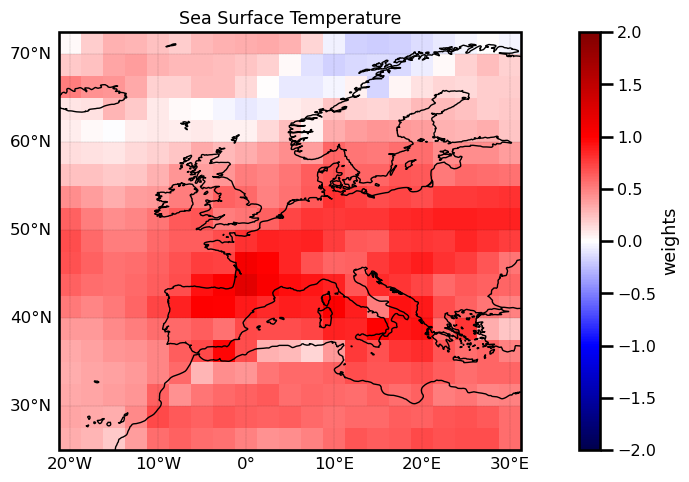

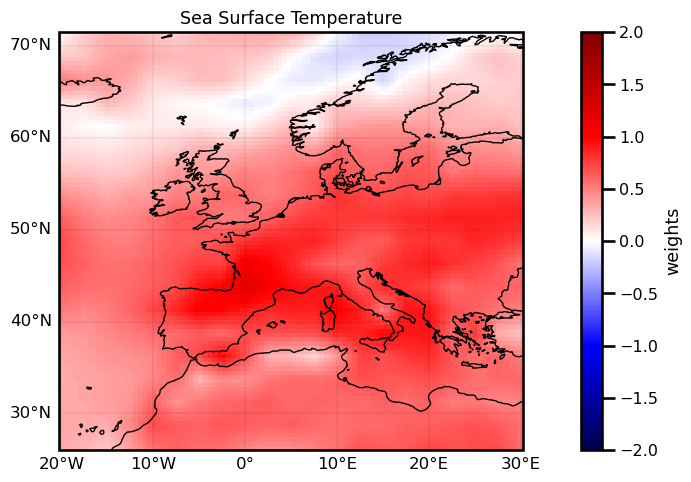

In [133]:
variable_name = "Sea Surface Temperature"
covariate = "sst"
plot_maps(covariate, variable_name)

### Soil Moisture

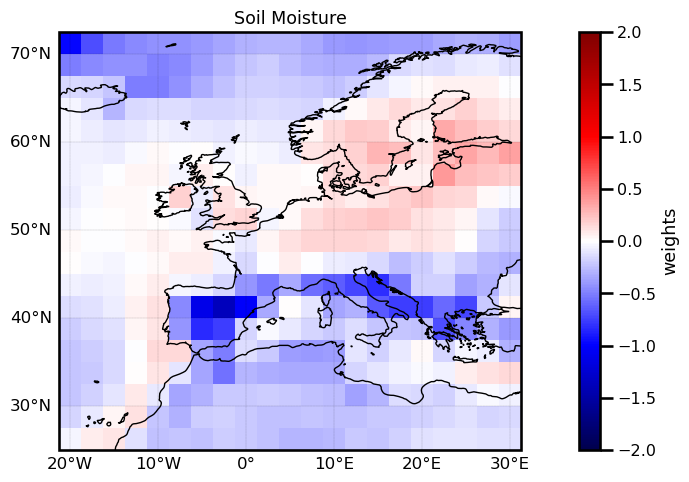

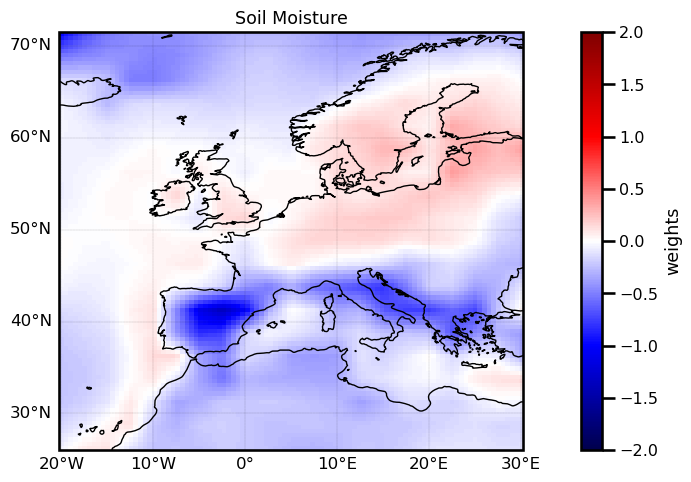

In [134]:
variable_name = "Soil Moisture"
covariate = "sm"

plot_maps(covariate, variable_name)

### 2m Temperature

In [135]:
# variable_name = "2m Temperature"
# covariate = "t2m"

# plot_maps(covariate, variable_name)

### Geopotential

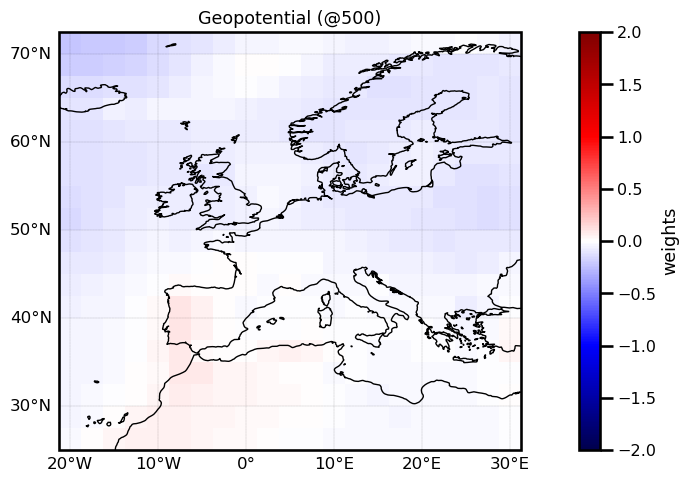

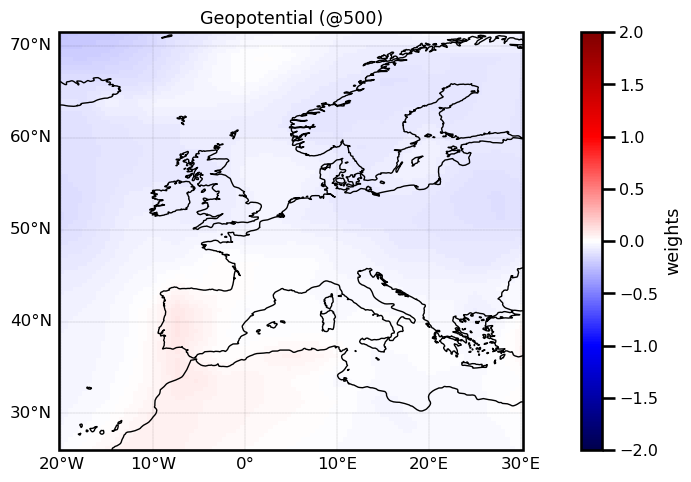

In [136]:
variable_name = "Geopotential (@500)"
covariate = "z500"

plot_maps(covariate, variable_name)

## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))